# SDLE - Sistemas Distribuídos em Larga Escala
## Trabalho prático - *Flow updating*

In [1]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import heapq as hq

Geração de grafos conectados.

In [2]:
def connectedGraph(nVertices):
    # Initialize the graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(nVertices))

    # List all possible edges
    edges = list(nx.non_edges(G))
    random.shuffle(edges)
    while not nx.is_connected(G):
        x, y = edges.pop()
        G.add_edge(x, y)

    return G

Exibição gráfica do grafo gerado.

In [3]:
def drawGraph(G):
    plt.figure(figsize = (16,8), dpi = 200)
    nx.draw_networkx(G,
                     with_labels = True,
                     style = "solid",
                     node_size = 700,
                     node_color = "orange",
                     font_size = 14,
                     font_color = "black",
                     font_weight = "bold")
    plt.show()

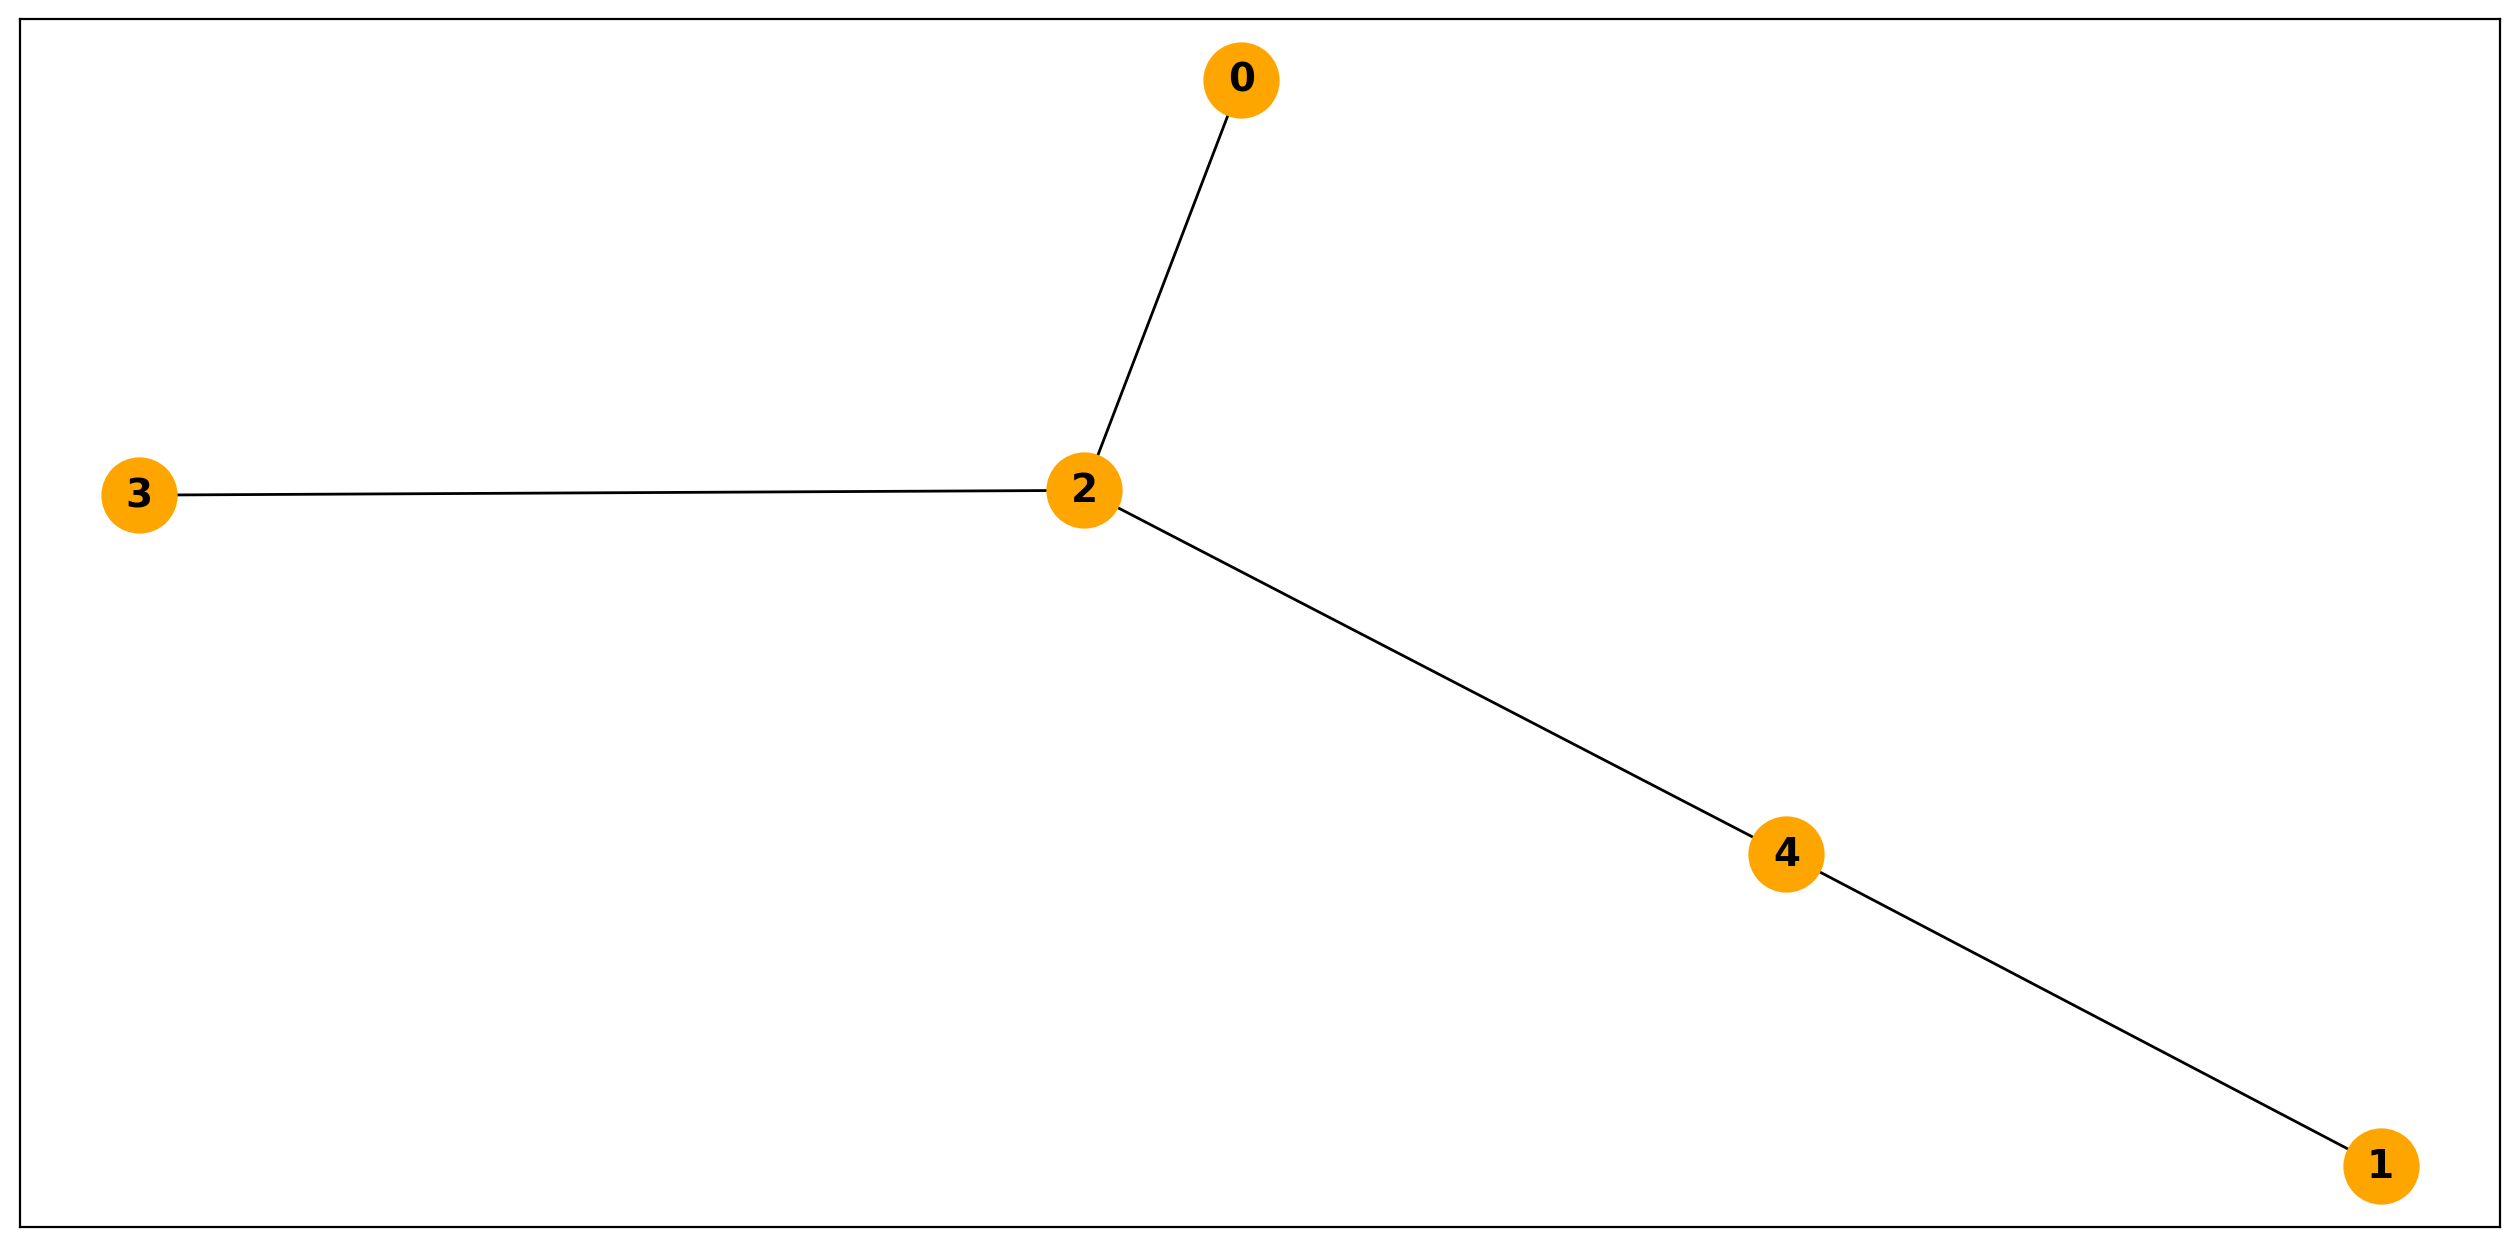

In [43]:
G = connectedGraph(5)
drawGraph(G)

Classe relativa à versão ***broadcast*** do algoritmo escolhido, isto é, ***flow updating*** :

In [76]:
class FlowUpdatingBroad:
    def __init__(self, neighbors, inputValue, timeout):
        self.timeout = timeout
        self.messages = []
        self.neighbors = neighbors
        self.f = {}
        self.e = {}
        for n in neighbors:
            self.f[n] = 0
            self.e[n] = 0
        self.v = inputValue
        
    def changeNeighbors(self, newNeighbors):
        newF, newE = {}, {}
            
        for n in newNeighbors:
            if n in self.neighbors:
                newF[n] = self.f[n]
                newE[n] = self.e[n]
            else:
                newF[n] = 0
                newE[n] = 0

        self.neighbors, self.f, self.e = newNeighbors, newF, newE

    def gen_message(self):
        messages = [("TIMEOUT", self.timeout, True)]
        for n in self.neighbors:
            msg = (self.f[n], self.e[n])
            messages.append(("FLOW", (n, msg)))
        return messages

    def calculateEstimate(self):
        sumF = 0
        sumE = 0
        for n in self.neighbors:
            sumF += self.f[n]
            sumE += self.e[n]
        return (self.v - sumF + sumE) / (len(self.neighbors) + 1)

    def state_transition(self):
        for m in self.messages:
            src = m[0]
            (f, e) = m[1]
            self.f[src] = -f
            self.e[src] = e
            
        self.messages = []

        newE = self.calculateEstimate()

        for n in self.neighbors:
            self.f[n] += newE - self.e[n]
            self.e[n] = newE

    def handle(self, src, msg):
        if msg == "INITIAL":
            return self.gen_message()
        else:
            if msg[0] == "FLOW":
                self.messages.append((src, msg[1]))
            else: # timeout message, end of round
                self.state_transition()
                return self.gen_message()
        return []

Classe relativa à versão ***unicast*** do algoritmo escolhido, isto é, ***flow updating*** :

In [77]:
class FlowUpdatingUni:
    def __init__(self, neighbors, inputValue, timeout):
        self.timeout = timeout
        self.messages = []
        self.neighbors = neighbors
        self.f = {}
        self.e = {}
        self.k = self.chooseNeighbor()
        for n in neighbors:
            self.f[n] = 0
            self.e[n] = 0
        self.v = inputValue

    def changeNeighbors(self, newNeighbors):
        newF, newE = {}, {}
            
        for n in newNeighbors:
            if n in self.neighbors:
                newF[n] = self.f[n]
                newE[n] = self.e[n]
            else:
                newF[n] = 0
                newE[n] = 0

        self.neighbors, self.f, self.e = newNeighbors, newF, newE
        
    def chooseNeighbor(self):
        return random.choice(list(self.neighbors))

    def gen_message(self):
        messages = [("TIMEOUT", self.timeout, True)]
        msg = (self.f[self.k], self.e[self.k])
        messages.append(("FLOW", (self.k, msg)))
        return messages

    def calculateEstimate(self):
        sumF = 0
        sumE = 0
        for n in self.neighbors:
            sumF += self.f[n]
            sumE += self.e[n]
        return (self.v - sumF + sumE) / (len(self.neighbors) + 1)

    def state_transition(self):
        for m in self.messages:
            src = m[0]
            (f, e) = m[1]
            self.f[src] = -f
            self.e[src] = e
            
        self.messages = []

        newE = self.calculateEstimate()

        self.k = self.chooseNeighbor()
        
        self.f[self.k] += newE - self.e[self.k]
        self.e[self.k] = newE

    def handle(self, src, msg):
        if msg == "INITIAL":
            return self.gen_message()
        else:
            if msg[0] == "FLOW":
                self.messages.append((src, msg[1]))
            else: # timeout message, end of round
                self.state_transition()
                return self.gen_message()
        return []

Classe *Simulator* :

In [78]:
class Simulator:
    def __init__(self, nodes, distances, faultProbability, viewChange, timeout):
        self.nodes = nodes
        self.distances = distances
        self.currentTime = 0
        self.pending = [] # [(delay, (src, dest, msg))]
        self.faultProbability = faultProbability
        self.viewChange = viewChange
        self.timeout = timeout

    def closeToTarget(self, target):
        currentEstimate, numEstimates = 0, 0
        for n in self.nodes.values():
            est = n.e.values()
            currentEstimate += sum(est)
            numEstimates += len(est)
        currentEstimate /= numEstimates

        print("----- ", target, currentEstimate)
        
        if abs(round(target, 3) - round(currentEstimate, 3)) <= 0.01:
            return True
        return False

    def start(self):
        # Calculate target value
        target = 0
        for node in self.nodes.values():
            target += node.v
        target /= len(self.nodes)

        # Generate initial messages
        for n in self.nodes:
            event = (0, (None, n, "INITIAL"))
            hq.heappush(self.pending, event)

        # Add first view change
        if self.viewChange != -1:
            hq.heappush(self.pending, (self.viewChange, (float("+infinity"), None, "VIEWCHANGE")))

        return self.runLoop(target)

    def runLoop(self, target):
        sent_messages = len(self.pending)
        while len(self.pending) != 0:
            if self.closeToTarget(target):
                break
            
            if len(self.pending) == 1:
                (delay, (src, dest, msg)) = self.pending[0]
                if msg != "VIEWCHANGE":
                    break

            (delay, (src, dest, msg)) = hq.heappop(self.pending)
            print(dest, "received", msg, "from", src, "at", delay)
            self.currentTime = delay

            # Message to change the view
            if msg == "VIEWCHANGE":
                print("View changing...")

                vc = (self.currentTime + self.viewChange, (float("+infinity"), None, "VIEWCHANGE"))
                print("VIEWCHANGE", vc)
                hq.heappush(self.pending, vc)

                newGraph = connectedGraph(len(self.nodes))
                drawGraph(newGraph)
                self.distances, self.nodes = newNeighborsAndDistances(newGraph, self.nodes, False, self.timeout)
                continue

            # Message between two nodes or a timeout
            newEvents = self.nodes[dest].handle(src, msg)

            if newEvents:
                #sent_messages += len(newEvents)
                for x in newEvents:
                    if x[0] != "TIMEOUT":
                        flag = False
                        sent_messages += 1
                        (msgType, (newMsgDest, newMsg)) = x
                        if self.faultProbability != 0 and random.randrange(round(1/self.faultProbability)) == 0: # fault-injection mechanism
                            print("Dropped", newMsg, "from", dest, "to", newMsgDest)
                            continue
                        dist = 0
                        if (dest, newMsgDest) not in self.distances and (newMsgDest, dest) not in self.distances:
                            print("Dropped one message from", dest, "to", newMsgDest, "because they are no longer neighbors")
                            continue
                        if dest < newMsgDest:
                            dist = self.distances[(dest, newMsgDest)]
                        else:
                            dist = self.distances[(newMsgDest, dest)]

                        ev = (self.currentTime + dist, (dest, newMsgDest, (msgType, newMsg)))
                        hq.heappush(self.pending, ev)
                    else:
                        (msgType, timeout, newMsg) = x
                        ev = (self.currentTime + timeout, (dest, dest, (msgType, timeout, newMsg)))
                        hq.heappush(self.pending, ev)
                        
        print()
        return sent_messages, (self.currentTime / self.timeout)

Função que determina os pesos das arestas do grafo gerado, instanciando o algoritmo em causa :

In [102]:
def newNeighborsAndDistances(G, nodes, flag, timeout):
    distances = {}
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        if flag:
            nodes[node] = FlowUpdatingUni(neighbors, random.randrange(1000000), timeout)
        else:
            nodes[node].changeNeighbors(neighbors)

        for neighbor in neighbors:
            if node < neighbor:
                distances[(node, neighbor)] = 1
            else:
                distances[(neighbor, node)] = 1

    return distances, nodes

In [103]:
def main():
    N = 5 # number of rounds
    fanout = 1
    messages_sent = 0
    rounds = 0
    timeout = 2
    max_rounds = float("-infinity")
    min_rounds = float("+infinity")

    for i in range(N):
        distances, nodes = newNeighborsAndDistances(G, {}, True, timeout)

        fp = 0 # fault-probability - probability for a message to be lost
        vcp = -1 # view-change periodicity - every vcp seconds, the set of neighbors change
        sim = Simulator(nodes, distances, fp, vcp, timeout)
        x, y = sim.start()
        messages_sent += x
        rounds += y

        if y > max_rounds:
            max_rounds = y
        if y < min_rounds:
            min_rounds = y

    print("Average rounds:", float(rounds / N))
    print("Average messages sent:", float(messages_sent / N))
    print("Min rounds:", min_rounds)
    print("Max rounds:", max_rounds)

In [104]:
main()

-----  486734.8 0.0
0 received INITIAL from None at 0
-----  486734.8 0.0
1 received INITIAL from None at 0
-----  486734.8 0.0
2 received INITIAL from None at 0
-----  486734.8 0.0
3 received INITIAL from None at 0
-----  486734.8 0.0
4 received INITIAL from None at 0
-----  486734.8 0.0
2 received ('FLOW', (0, 0)) from 0 at 1
-----  486734.8 0.0
4 received ('FLOW', (0, 0)) from 1 at 1
-----  486734.8 0.0
3 received ('FLOW', (0, 0)) from 2 at 1
-----  486734.8 0.0
2 received ('FLOW', (0, 0)) from 3 at 1
-----  486734.8 0.0
1 received ('FLOW', (0, 0)) from 4 at 1
-----  486734.8 0.0
0 received ('TIMEOUT', 2, True) from 0 at 2
-----  486734.8 48387.8125
1 received ('TIMEOUT', 2, True) from 1 at 2
-----  486734.8 85030.1875
2 received ('TIMEOUT', 2, True) from 2 at 2
-----  486734.8 99594.1875
3 received ('TIMEOUT', 2, True) from 3 at 2
-----  486734.8 118315.625
4 received ('TIMEOUT', 2, True) from 4 at 2
-----  486734.8 131132.29166666666
2 received ('FLOW', (387102.5, 387102.5)) from 

2 received ('FLOW', (-69104.0740740741, 481491.037037037)) from 4 at 21
-----  486734.8 479108.9675925925
0 received ('TIMEOUT', 2, True) from 0 at 22
-----  486734.8 486407.0648148148
1 received ('TIMEOUT', 2, True) from 1 at 22
-----  486734.8 486407.0648148148
2 received ('TIMEOUT', 2, True) from 2 at 22
-----  486734.8 476650.9537037037
3 received ('TIMEOUT', 2, True) from 3 at 22
-----  486734.8 476650.9537037037
4 received ('TIMEOUT', 2, True) from 4 at 22
-----  486734.8 479928.30555555556
2 received ('FLOW', (279604.55555555556, 494600.44444444444)) from 0 at 23
-----  486734.8 479928.30555555556
4 received ('FLOW', (104786.96296296298, 481491.037037037)) from 1 at 23
-----  486734.8 479928.30555555556
3 received ('FLOW', (188502.74074074073, 488045.74074074073)) from 2 at 23
-----  486734.8 479928.30555555556
2 received ('FLOW', (-195057.44444444444, 494600.44444444444)) from 3 at 23
-----  486734.8 479928.30555555556
2 received ('FLOW', (-69104.0740740741, 481491.037037037)) 

-----  486734.8 486657.4180812757
1 received ('TIMEOUT', 2, True) from 1 at 46
-----  486734.8 486748.455632716
2 received ('TIMEOUT', 2, True) from 2 at 46
-----  486734.8 486725.69624485594
3 received ('TIMEOUT', 2, True) from 3 at 46
-----  486734.8 486725.69624485594
4 received ('TIMEOUT', 2, True) from 4 at 46
-----  486734.8 486763.6285579561
2 received ('FLOW', (287251.7098765432, 486953.2901234568)) from 0 at 47
-----  486734.8 486763.6285579561
4 received ('FLOW', (99688.86008230457, 486589.13991769543)) from 1 at 47
-----  486734.8 486763.6285579561
0 received ('FLOW', (-287433.7849794239, 486771.2150205761)) from 2 at 47
-----  486734.8 486763.6285579561
2 received ('FLOW', (-187228.21502057614, 486771.21502057614)) from 3 at 47
-----  486734.8 486763.6285579561
1 received ('FLOW', (-99567.47668038408, 486710.5233196159)) from 4 at 47
-----  486734.8 486763.6285579561
0 received ('TIMEOUT', 2, True) from 0 at 48
-----  486734.8 486740.869170096
1 received ('TIMEOUT', 2, True

1 received ('FLOW', (-99547.24611339741, 486730.7538866026)) from 4 at 69
-----  486734.8 486735.1793231309
0 received ('TIMEOUT', 2, True) from 0 at 70
-----  486734.8 486734.5471179126
1 received ('TIMEOUT', 2, True) from 1 at 70
-----  486734.8 486734.5471179126
2 received ('TIMEOUT', 2, True) from 2 at 70
-----  486734.8 486735.81152834924
3 received ('TIMEOUT', 2, True) from 3 at 70
-----  486734.8 486735.81152834924
4 received ('TIMEOUT', 2, True) from 4 at 70
-----  486734.8 486735.81152834924
2 received ('FLOW', (287469.1884716507, 486735.8115283493)) from 0 at 71
-----  486734.8 486735.81152834924
4 received ('FLOW', (99547.24611339741, 486730.7538866026)) from 1 at 71
-----  486734.8 486735.81152834924
4 received ('FLOW', (79588.565414952, 486735.8115283493)) from 2 at 71
-----  486734.8 486735.81152834924
2 received ('FLOW', (-187197.869170096, 486740.869170096)) from 3 at 71
-----  486734.8 486735.81152834924
1 received ('FLOW', (-99547.24611339741, 486730.7538866026)) from

2 received ('FLOW', (-187191.96858805825, 486734.96858805825)) from 3 at 99
-----  486734.8 486734.8339517617
2 received ('FLOW', (-79591.56253598706, 486734.78126799344)) from 4 at 99
-----  486734.8 486734.8339517617
0 received ('TIMEOUT', 2, True) from 0 at 100
-----  486734.8 486734.8339517617
1 received ('TIMEOUT', 2, True) from 1 at 100
-----  486734.8 486734.8339517617
2 received ('TIMEOUT', 2, True) from 2 at 100
-----  486734.8 486734.83687863767
3 received ('TIMEOUT', 2, True) from 3 at 100
-----  486734.8 486734.83687863767
4 received ('TIMEOUT', 2, True) from 4 at 100
-----  486734.8 486734.83687863767
2 received ('FLOW', (287470.1953169984, 486734.8046830016)) from 0 at 101
-----  486734.8 486734.83687863767
4 received ('FLOW', (99543.21873200656, 486734.78126799344)) from 1 at 101
-----  486734.8 486734.83687863767
4 received ('FLOW', (79591.58595099521, 486734.8046830016)) from 2 at 101
-----  486734.8 486734.83687863767
2 received ('FLOW', (-187191.96858805825, 486734.9

-----  824721.0 816499.1042148919
2 received ('FLOW', (175245.43171296304, 824421.568287037)) from 3 at 29
-----  824721.0 816499.1042148919
1 received ('FLOW', (-110250.37885802472, 824920.6211419753)) from 4 at 29
-----  824721.0 816499.1042148919
0 received ('TIMEOUT', 2, True) from 0 at 30
-----  824721.0 824546.3315007716
1 received ('TIMEOUT', 2, True) from 1 at 30
-----  824721.0 824546.3315007716
2 received ('TIMEOUT', 2, True) from 2 at 30
-----  824721.0 824733.4763213734
3 received ('TIMEOUT', 2, True) from 3 at 30
-----  824721.0 824733.4763213734
4 received ('TIMEOUT', 2, True) from 4 at 30
-----  824721.0 824795.8579282407
2 received ('FLOW', (156969.43171296304, 824421.568287037)) from 0 at 31
-----  824721.0 824795.8579282407
4 received ('FLOW', (110250.37885802472, 824920.6211419753)) from 1 at 31
-----  824721.0 824795.8579282407
0 received ('FLOW', (-156969.43171296304, 824421.568287037)) from 2 at 31
-----  824721.0 824795.8579282407
2 received ('FLOW', (175245.4317

-----  824721.0 824718.7473308631
2 received ('FLOW', (156678.31754758232, 824712.6824524177)) from 0 at 51
-----  824721.0 824718.7473308631
4 received ('FLOW', (110444.45496827841, 824726.5450317216)) from 1 at 51
-----  824721.0 824718.7473308631
4 received ('FLOW', (269498.15877379116, 824719.6137420697)) from 2 at 51
-----  824721.0 824718.7473308631
2 received ('FLOW', (174954.31754758232, 824712.6824524177)) from 3 at 51
-----  824721.0 824718.7473308631
2 received ('FLOW', (-269505.09006344306, 824726.5450317216)) from 4 at 51
-----  824721.0 824718.7473308631
0 received ('TIMEOUT', 2, True) from 0 at 52
-----  824721.0 824718.7473308631
1 received ('TIMEOUT', 2, True) from 1 at 52
-----  824721.0 824718.7473308631
2 received ('TIMEOUT', 2, True) from 2 at 52
-----  824721.0 824718.7473308631
3 received ('TIMEOUT', 2, True) from 3 at 52
-----  824721.0 824718.7473308631
4 received ('TIMEOUT', 2, True) from 4 at 52
-----  824721.0 824718.1697233921
2 received ('FLOW', (156678.31

2 received ('FLOW', (56459.66666666663, 664811.3333333334)) from 0 at 9
-----  734570.0 591482.6197916666
4 received ('FLOW', (69601.83333333337, 636318.1666666666)) from 1 at 9
-----  734570.0 591482.6197916666
0 received ('FLOW', (37861.958333333256, 759132.9583333333)) from 2 at 9
-----  734570.0 591482.6197916666
2 received ('FLOW', (381322.0, 381322.0)) from 3 at 9
-----  734570.0 591482.6197916666
1 received ('FLOW', (-69601.83333333337, 636318.1666666666)) from 4 at 9
-----  734570.0 591482.6197916666
0 received ('TIMEOUT', 2, True) from 0 at 10
-----  734570.0 603272.8229166666
1 received ('TIMEOUT', 2, True) from 1 at 10
-----  734570.0 603272.8229166666
2 received ('TIMEOUT', 2, True) from 2 at 10
-----  734570.0 603272.8229166666
3 received ('TIMEOUT', 2, True) from 3 at 10
-----  734570.0 603272.8229166666
4 received ('TIMEOUT', 2, True) from 4 at 10
-----  734570.0 603272.8229166666
2 received ('FLOW', (-37861.958333333256, 759132.9583333333)) from 0 at 11
-----  734570.0 

3 received ('TIMEOUT', 2, True) from 3 at 32
-----  734570.0 735252.3043981482
4 received ('TIMEOUT', 2, True) from 4 at 32
-----  734570.0 735536.5978973766
2 received ('FLOW', (-17392.826388888876, 738663.8263888889)) from 0 at 33
-----  734570.0 735536.5978973766
4 received ('FLOW', (-25920.7824074073, 731840.7824074073)) from 1 at 33
-----  734570.0 735536.5978973766
0 received ('FLOW', (13981.304398148204, 735252.3043981482)) from 2 at 33
-----  734570.0 735536.5978973766
2 received ('FLOW', (23980.173611111008, 738663.826388889)) from 3 at 33
-----  734570.0 735536.5978973766
2 received ('FLOW', (160743.73919753078, 734115.1304012346)) from 4 at 33
-----  734570.0 735536.5978973766
0 received ('TIMEOUT', 2, True) from 0 at 34
-----  734570.0 735110.157648534
1 received ('TIMEOUT', 2, True) from 1 at 34
-----  734570.0 735110.157648534
2 received ('TIMEOUT', 2, True) from 2 at 34
-----  734570.0 734896.9375241126
3 received ('TIMEOUT', 2, True) from 3 at 34
-----  734570.0 734896.

2 received ('FLOW', (27960.282600308536, 734683.7173996915)) from 3 at 51
-----  734570.0 734585.004379126
2 received ('FLOW', (159859.27053326485, 734557.3647333677)) from 4 at 51
-----  734570.0 734585.004379126
0 received ('TIMEOUT', 2, True) from 0 at 52
-----  734570.0 734585.004379126
1 received ('TIMEOUT', 2, True) from 1 at 52
-----  734570.0 734585.004379126
2 received ('TIMEOUT', 2, True) from 2 at 52
-----  734570.0 734583.0301187147
3 received ('TIMEOUT', 2, True) from 3 at 52
-----  734570.0 734583.0301187147
4 received ('TIMEOUT', 2, True) from 4 at 52
-----  734570.0 734594.8756811825
2 received ('FLOW', (-13317.952899948461, 734588.9528999485)) from 0 at 53
-----  734570.0 734594.8756811825
4 received ('FLOW', (-28574.188400205807, 734494.1884002058)) from 1 at 53
-----  734570.0 734594.8756811825
4 received ('FLOW', (-159843.47644997435, 734573.1588166582)) from 2 at 53
-----  734570.0 734594.8756811825
2 received ('FLOW', (27960.282600308536, 734683.7173996915)) from 

1 received ('FLOW', (28649.94150339521, 734569.9415033952)) from 4 at 73
-----  734570.0 734570.1334453797
0 received ('TIMEOUT', 2, True) from 0 at 74
-----  734570.0 734570.1334453797
1 received ('TIMEOUT', 2, True) from 1 at 74
-----  734570.0 734570.1334453797
2 received ('TIMEOUT', 2, True) from 2 at 74
-----  734570.0 734570.1334453797
3 received ('TIMEOUT', 2, True) from 3 at 74
-----  734570.0 734570.1334453797
4 received ('TIMEOUT', 2, True) from 4 at 74
-----  734570.0 734570.1395387759
2 received ('FLOW', (-13299.526469442993, 734570.526469443)) from 0 at 75
-----  734570.0 734570.1395387759
4 received ('FLOW', (-28649.94150339521, 734569.9415033952)) from 1 at 75
-----  734570.0 734570.1395387759
4 received ('FLOW', (-159834.04387245374, 734570.0146241512)) from 2 at 75
-----  734570.0 734570.1395387759
2 received ('FLOW', (28073.912255092757, 734570.0877449072)) from 3 at 75
-----  734570.0 734570.1395387759
2 received ('FLOW', (159834.01949886826, 734569.9902505657)) from

4 received ('TIMEOUT', 2, True) from 4 at 16
-----  777977.4 769182.7361111111
2 received ('FLOW', (7569.666666666744, 832358.3333333333)) from 0 at 17
-----  777977.4 769182.7361111111
4 received ('FLOW', (230681.5555555555, 741723.4444444445)) from 1 at 17
-----  777977.4 769182.7361111111
4 received ('FLOW', (-288549.0, 832358.3333333333)) from 2 at 17
-----  777977.4 769182.7361111111
2 received ('FLOW', (7251.166666666628, 670290.8333333334)) from 3 at 17
-----  777977.4 769182.7361111111
1 received ('FLOW', (-230681.5555555555, 741723.4444444445)) from 4 at 17
-----  777977.4 769182.7361111111
0 received ('TIMEOUT', 2, True) from 0 at 18
-----  777977.4 769182.7361111111
1 received ('TIMEOUT', 2, True) from 1 at 18
-----  777977.4 769182.7361111111
2 received ('TIMEOUT', 2, True) from 2 at 18
-----  777977.4 769182.7361111111
3 received ('TIMEOUT', 2, True) from 3 at 18
-----  777977.4 769182.7361111111
4 received ('TIMEOUT', 2, True) from 4 at 18
-----  777977.4 757853.375
2 rec

1 received ('TIMEOUT', 2, True) from 1 at 52
-----  777977.4 778124.2620884774
2 received ('TIMEOUT', 2, True) from 2 at 52
-----  777977.4 778124.2620884774
3 received ('TIMEOUT', 2, True) from 3 at 52
-----  777977.4 778124.2620884774
4 received ('TIMEOUT', 2, True) from 4 at 52
-----  777977.4 777966.909850823
2 received ('FLOW', (61698.83641975315, 778229.1635802469)) from 0 at 53
-----  777977.4 777966.909850823
4 received ('FLOW', (194595.44238683116, 777809.5576131688)) from 1 at 53
-----  777977.4 777966.909850823
4 received ('FLOW', (-126161.49074074056, 778229.1635802469)) from 2 at 53
-----  777977.4 777966.909850823
2 received ('FLOW', (-100687.16358024685, 778229.1635802469)) from 3 at 53
-----  777977.4 777966.909850823
2 received ('FLOW', (125741.88477366255, 777809.5576131688)) from 4 at 53
-----  777977.4 777966.909850823
0 received ('TIMEOUT', 2, True) from 0 at 54
-----  777977.4 777966.909850823
1 received ('TIMEOUT', 2, True) from 1 at 54
-----  777977.4 777966.909

-----  777977.4 777982.2079850395
2 received ('FLOW', (-100435.59426202171, 777977.5942620217)) from 3 at 79
-----  777977.4 777982.2079850395
2 received ('FLOW', (125407.7540961745, 777976.6229519128)) from 4 at 79
-----  777977.4 777982.2079850395
0 received ('TIMEOUT', 2, True) from 0 at 80
-----  777977.4 777982.2079850395
1 received ('TIMEOUT', 2, True) from 1 at 80
-----  777977.4 777982.2079850395
2 received ('TIMEOUT', 2, True) from 2 at 80
-----  777977.4 777976.9871932038
3 received ('TIMEOUT', 2, True) from 3 at 80
-----  777977.4 777976.9871932038
4 received ('TIMEOUT', 2, True) from 4 at 80
-----  777977.4 777977.5537907673
2 received ('FLOW', (61949.43442786927, 777978.5655721307)) from 0 at 81
-----  777977.4 777977.5537907673
4 received ('FLOW', (194428.3770480872, 777976.6229519128)) from 1 at 81
-----  777977.4 777977.5537907673
4 received ('FLOW', (-125406.78278606548, 777977.5942620218)) from 2 at 81
-----  777977.4 777977.5537907673
2 received ('FLOW', (-100435.594

2 received ('FLOW', (249023.83333333326, 491457.16666666674)) from 3 at 13
-----  510755.2 414715.7673611111
1 received ('FLOW', (280142.55555555556, 523620.55555555556)) from 4 at 13
-----  510755.2 414715.7673611111
0 received ('TIMEOUT', 2, True) from 0 at 14
-----  510755.2 414715.7673611111
1 received ('TIMEOUT', 2, True) from 1 at 14
-----  510755.2 439588.8368055555
2 received ('TIMEOUT', 2, True) from 2 at 14
-----  510755.2 456751.1319444444
3 received ('TIMEOUT', 2, True) from 3 at 14
-----  510755.2 456751.1319444444
4 received ('TIMEOUT', 2, True) from 4 at 14
-----  510755.2 453400.7789351851
2 received ('FLOW', (25531.75, 288306.25)) from 0 at 15
-----  510755.2 453400.7789351851
4 received ('FLOW', (-280142.55555555556, 523620.55555555556)) from 1 at 15
-----  510755.2 453400.7789351851
3 received ('FLOW', (-232942.13888888893, 507538.86111111107)) from 2 at 15
-----  510755.2 453400.7789351851
2 received ('FLOW', (249023.83333333326, 491457.16666666674)) from 3 at 15
--

0 received ('TIMEOUT', 2, True) from 0 at 34
-----  510755.2 510935.7468010545
1 received ('TIMEOUT', 2, True) from 1 at 34
-----  510755.2 510675.16378922324
2 received ('TIMEOUT', 2, True) from 2 at 34
-----  510755.2 510740.309542181
3 received ('TIMEOUT', 2, True) from 3 at 34
-----  510755.2 510740.309542181
4 received ('TIMEOUT', 2, True) from 4 at 34
-----  510755.2 510724.7986486197
2 received ('FLOW', (-196827.8572530864, 510665.8572530864)) from 0 at 35
-----  510755.2 510724.7986486197
4 received ('FLOW', (-267336.7618312757, 510814.7618312757)) from 1 at 35
-----  510755.2 510724.7986486197
0 received ('FLOW', (196902.3095421811, 510740.3095421811)) from 2 at 35
-----  510755.2 510724.7986486197
2 received ('FLOW', (229815.14274691354, 510665.85725308646)) from 3 at 35
-----  510755.2 510724.7986486197
1 received ('FLOW', (267287.12697187933, 510765.12697187933)) from 4 at 35
-----  510755.2 510724.7986486197
0 received ('TIMEOUT', 2, True) from 0 at 36
-----  510755.2 5107

-----  510755.2 510754.8940907103
4 received ('FLOW', (47602.434468652296, 510755.1885104492)) from 2 at 61
-----  510755.2 510754.8940907103
2 received ('FLOW', (229726.2136238283, 510754.7863761717)) from 3 at 61
-----  510755.2 510754.8940907103
2 received ('FLOW', (-47602.49191640626, 510755.24595820316)) from 4 at 61
-----  510755.2 510754.8940907103
0 received ('TIMEOUT', 2, True) from 0 at 62
-----  510755.2 510754.8940907103
1 received ('TIMEOUT', 2, True) from 1 at 62
-----  510755.2 510754.8940907103
2 received ('TIMEOUT', 2, True) from 2 at 62
-----  510755.2 510755.21005335695
3 received ('TIMEOUT', 2, True) from 3 at 62
-----  510755.2 510755.21005335695
4 received ('TIMEOUT', 2, True) from 4 at 62
-----  510755.2 510755.2052660441

Average rounds: 41.6
Average messages sent: 217.6
Min rounds: 31.0
Max rounds: 53.0
